In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, LSTM, GRU, Conv1D, Conv2D, MaxPooling1D, GlobalAveragePooling1D,
    Dropout, BatchNormalization, Input, Concatenate, Add, Multiply,
    LayerNormalization, MultiHeadAttention, Embedding, Flatten,
    SeparableConv1D, DepthwiseConv2D, GlobalMaxPooling1D
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
#suppress tensorflow  warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [4]:
x_seq=np.load(r"C:\Users\Josemiles\Desktop\GaitLab\src\Datasets\ts_data\x_seq_len64_stride32.npy")
y_seq=np.load(r"C:\Users\Josemiles\Desktop\GaitLab\src\Datasets\ts_data\y_seq_len64_stride32.npy")
meta_data=pd.read_csv(r"C:\Users\Josemiles\Desktop\GaitLab\src\Datasets\ts_data\meta_seq_len64_stride32.csv")

In [ ]:
x_seq

array([[[ 0.32312822,  0.47143033,  0.38068298, ...,  0.2713345 ,
          0.60168755, -1.4359491 ],
        [ 0.32312822,  0.47143033,  0.38068298, ...,  0.2713345 ,
          0.60168755, -1.4359491 ],
        [ 0.32312822,  0.47143033,  0.38068298, ...,  0.2713345 ,
          0.60168755, -1.4359491 ],
        ...,
        [ 0.18642431,  0.4829002 ,  0.23715465, ..., -0.12840074,
          0.34515643, -1.2990065 ],
        [ 0.118697  ,  0.454363  ,  0.2410828 , ..., -0.29701573,
          0.28353518, -1.2874126 ],
        [-0.05301055,  0.437391  ,  0.31696898, ..., -0.7774501 ,
          0.3087622 , -1.2743423 ]],

       [[ 0.32312822,  0.47143033,  0.38068298, ...,  0.2713345 ,
          0.60168755, -1.4359491 ],
        [ 0.32312822,  0.47143033,  0.38068298, ...,  0.2713345 ,
          0.60168755, -1.4359491 ],
        [ 0.32312822,  0.47143033,  0.38068298, ...,  0.2713345 ,
          0.60168755, -1.4359491 ],
        ...,
        [ 0.39133498, -0.15758546,  0.387898  , ..., -

In [ ]:
y_seq

array(['KOA_Early', 'KOA_Early', 'KOA_Early', ..., 'NonAssistive',
       'NonAssistive', 'NonAssistive'], dtype='<U12')

In [ ]:
meta_data.head()

,video_file,start_frame,end_frame,label
0,001_KOA_01_EL_KOA_Early.csv,0,64,KOA_Early
1,001_KOA_01_EL_KOA_Early.csv,32,96,KOA_Early
2,001_KOA_01_EL_KOA_Early.csv,64,128,KOA_Early
3,001_KOA_01_EL_KOA_Early.csv,96,160,KOA_Early
4,001_KOA_01_EL_KOA_Early.csv,128,192,KOA_Early


## Data Overview

Let's examine the loaded gait dataset and understand its structure.

# Advanced Gait Analysis Model Implementation

This notebook implements an advanced deep learning model for gait-based pathology detection using temporal convolutional networks with attention mechanisms.

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

Data Shapes:
X_seq shape: (2204, 64, 21)
Y_seq shape: (2204,)
Meta data shape: (2204, 4)

Data Statistics:
X_seq - Min: nan, Max: nan, Mean: nan
Unique labels in y_seq: ['Assistive' 'KOA_Early' 'KOA_Mild' 'KOA_Severe' 'NonAssistive' 'Normal'
 'PD_Early' 'PD_Mild' 'PD_Severe']


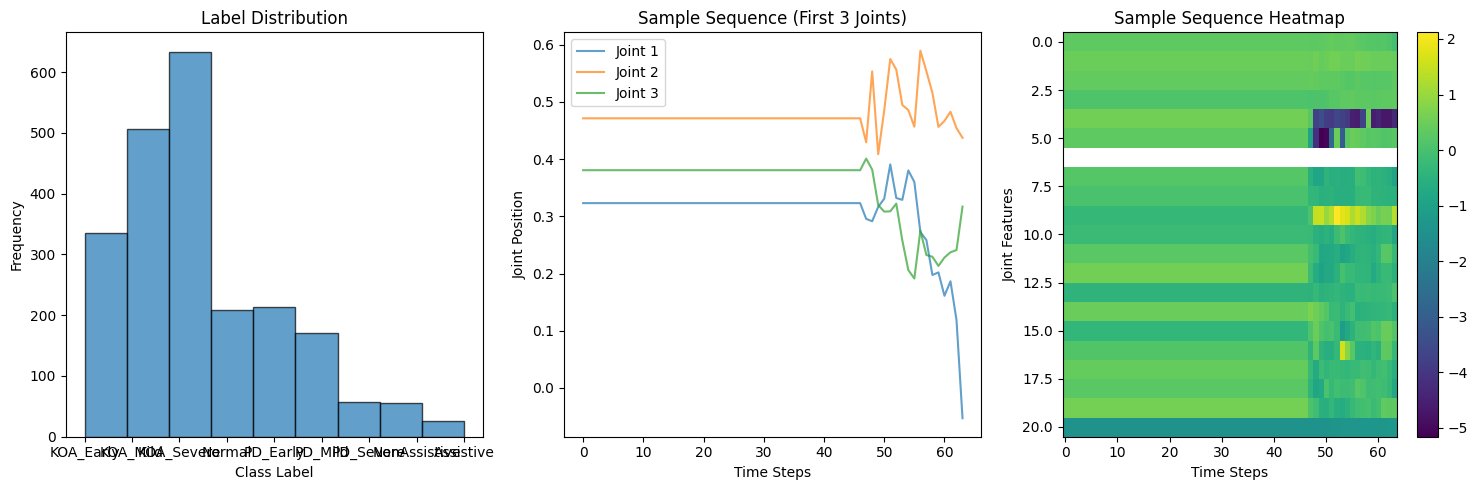

In [ ]:
# Data Exploration and Preprocessing
print("Data Shapes:")
print(f"X_seq shape: {x_seq.shape}")
print(f"Y_seq shape: {y_seq.shape}")
print(f"Meta data shape: {meta_data.shape}")

# Check data statistics
print("\nData Statistics:")
print(f"X_seq - Min: {x_seq.min():.3f}, Max: {x_seq.max():.3f}, Mean: {x_seq.mean():.3f}")
print(f"Unique labels in y_seq: {np.unique(y_seq)}")
print(f"Label distribution: {np.bincount(y_seq)}")

# Visualize data distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(y_seq, bins=len(np.unique(y_seq)), alpha=0.7, edgecolor='black')
plt.title('Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(x_seq[0, :, 0], alpha=0.7, label='Joint 1')
plt.plot(x_seq[0, :, 1], alpha=0.7, label='Joint 2')
plt.plot(x_seq[0, :, 2], alpha=0.7, label='Joint 3')
plt.title('Sample Sequence (First 3 Joints)')
plt.xlabel('Time Steps')
plt.ylabel('Joint Position')
plt.legend()

plt.subplot(1, 3, 3)
plt.imshow(x_seq[0].T, aspect='auto', cmap='viridis')
plt.title('Sample Sequence Heatmap')
plt.xlabel('Time Steps')
plt.ylabel('Joint Features')
plt.colorbar()

plt.tight_layout()
plt.show()

## Advanced Model Architecture: Hybrid Attention-TCN

We'll implement a sophisticated model combining:
1. **Temporal Convolutional Networks (TCN)** - For capturing long-range temporal dependencies
2. **Multi-Head Attention** - For learning important feature relationships
3. **Residual Connections** - For better gradient flow
4. **Channel Attention** - For feature importance weighting

In [7]:
class ChannelAttention(tf.keras.layers.Layer):
    """Channel attention mechanism for feature importance weighting"""
    
    def __init__(self, reduction_ratio=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        self.channel_axis = -1
        self.channels = input_shape[self.channel_axis]
        
        self.global_avg_pool = GlobalAveragePooling1D()
        self.global_max_pool = GlobalMaxPooling1D()
        
        self.dense1 = Dense(self.channels // self.reduction_ratio, activation='relu')
        self.dense2 = Dense(self.channels, activation='sigmoid')
        
        super(ChannelAttention, self).build(input_shape)
    
    def call(self, inputs):
        # Global average pooling
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = tf.expand_dims(avg_pool, axis=1)
        
        # Global max pooling
        max_pool = self.global_max_pool(inputs)
        max_pool = tf.expand_dims(max_pool, axis=1)
        
        # Shared dense layers
        avg_pool = self.dense2(self.dense1(avg_pool))
        max_pool = self.dense2(self.dense1(max_pool))
        
        # Combine and apply attention
        attention = avg_pool + max_pool
        return inputs * attention


class TCNBlock(tf.keras.layers.Layer):
    """Temporal Convolutional Network block with residual connections"""
    
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout_rate=0.2, **kwargs):
        super(TCNBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.conv1 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            dilation_rate=self.dilation_rate,
            padding='causal',
            activation='relu'
        )
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(self.dropout_rate)
        
        self.conv2 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            dilation_rate=self.dilation_rate,
            padding='causal',
            activation='relu'
        )
        self.bn2 = BatchNormalization()
        self.dropout2 = Dropout(self.dropout_rate)
        
        # Residual connection
        if input_shape[-1] != self.filters:
            self.residual_conv = Conv1D(filters=self.filters, kernel_size=1, padding='same')
        else:
            self.residual_conv = None
            
        super(TCNBlock, self).build(input_shape)
    
    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)
        
        # Residual connection
        if self.residual_conv is not None:
            residual = self.residual_conv(inputs)
        else:
            residual = inputs
            
        return Add()([x, residual])


def create_hybrid_attention_tcn_model(input_shape, num_classes, tcn_filters=[64, 128, 256], 
                                    attention_heads=8, dropout_rate=0.3):
    """
    Create Hybrid Attention-TCN model for gait analysis
    
    Args:
        input_shape: Shape of input data (timesteps, features)
        num_classes: Number of output classes
        tcn_filters: List of filter sizes for TCN blocks
        attention_heads: Number of attention heads
        dropout_rate: Dropout rate
    
    Returns:
        Compiled Keras model
    """
    
    inputs = Input(shape=input_shape, name='gait_sequence')
    
    # Initial feature extraction
    x = Conv1D(filters=64, kernel_size=7, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # TCN blocks with increasing dilation rates
    for i, filters in enumerate(tcn_filters):
        dilation_rate = 2 ** i
        x = TCNBlock(
            filters=filters,
            kernel_size=3,
            dilation_rate=dilation_rate,
            dropout_rate=dropout_rate
        )(x)
    
    # Channel attention
    x = ChannelAttention(reduction_ratio=16)(x)
    
    # Multi-head attention
    attention_output = MultiHeadAttention(
        num_heads=attention_heads,
        key_dim=tcn_filters[-1] // attention_heads,
        dropout=dropout_rate
    )(x, x)
    
    # Residual connection with attention
    x = Add()([x, attention_output])
    x = LayerNormalization()(x)
    
    # Additional TCN processing
    x = TCNBlock(filters=512, kernel_size=3, dilation_rate=1, dropout_rate=dropout_rate)(x)
    x = TCNBlock(filters=256, kernel_size=3, dilation_rate=2, dropout_rate=dropout_rate)(x)
    
    # Global feature extraction
    global_avg = GlobalAveragePooling1D()(x)
    global_max = GlobalMaxPooling1D()(x)
    
    # Combine global features
    combined_features = Concatenate()([global_avg, global_max])
    
    # Dense layers for classification
    x = Dense(512, activation='relu')(combined_features)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate / 2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate / 2)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax', name='classification')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='HybridAttentionTCN')
    
    return model

print("✓ Hybrid Attention-TCN Model Architecture Defined")

✓ Hybrid Attention-TCN Model Architecture Defined


In [ ]:
# Data Preprocessing and Preparation
def prepare_data(x_seq, y_seq, test_size=0.2, validation_size=0.2, random_state=42):
    """
    Prepare data for training with proper scaling and splitting
    """
    print("Preparing data for training...")
    
    # Normalize input features
    scaler = StandardScaler()
    
    # Reshape for scaling
    original_shape = x_seq.shape
    x_reshaped = x_seq.reshape(-1, x_seq.shape[-1])
    
    # Fit and transform
    x_scaled = scaler.fit_transform(x_reshaped)
    x_scaled = x_scaled.reshape(original_shape)
    
    # Encode string labels to integers first
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_seq)
    
    # Convert labels to categorical
    num_classes = len(np.unique(y_encoded))
    y_categorical = to_categorical(y_encoded, num_classes=num_classes)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        x_scaled, y_categorical, 
        test_size=test_size, 
        stratify=y_encoded,  # Use encoded labels for stratification
        random_state=random_state
    )
    
    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=validation_size,
        stratify=np.argmax(y_train, axis=1),
        random_state=random_state
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Class names: {label_encoder.classes_}")
    
    return (X_train, X_val, X_test, y_train, y_val, y_test), scaler, num_classes, label_encoder

# Prepare the data
data_splits, scaler, num_classes, label_encoder = prepare_data(x_seq, y_seq)
X_train, X_val, X_test, y_train, y_val, y_test = data_splits

print("✓ Data preparation completed")

Preparing data for training...


ValueError: invalid literal for int() with base 10: 'KOA_Early'

In [ ]:
# Create and compile the Hybrid Attention-TCN model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

model = create_hybrid_attention_tcn_model(
    input_shape=input_shape,
    num_classes=num_classes,
    tcn_filters=[64, 128, 256],
    attention_heads=8,
    dropout_rate=0.3
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model summary
print("Model Architecture Summary:")
print("=" * 50)
model.summary()

# Plot model architecture (if possible)
try:
    tf.keras.utils.plot_model(
        model, 
        to_file='hybrid_attention_tcn_model.png', 
        show_shapes=True, 
        show_layer_names=True,
        rankdir='TB',
        dpi=150
    )
    print("✓ Model architecture diagram saved as 'hybrid_attention_tcn_model.png'")
except:
    print("Note: Could not save model diagram (graphviz not installed)")

print(f"✓ Model created with {model.count_params():,} parameters")

## Model Training with Advanced Callbacks

Training the model with sophisticated callbacks for optimal performance.

In [ ]:
# Training Configuration and Callbacks
def create_callbacks(model_name="hybrid_attention_tcn"):
    """Create training callbacks for optimal performance"""
    
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Save best model
        ModelCheckpoint(
            filepath=f'best_{model_name}_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]
    
    return callbacks

# Create callbacks
callbacks = create_callbacks("hybrid_attention_tcn")

# Training parameters
EPOCHS = 100
BATCH_SIZE = 32

print("Training Configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Training Samples: {len(X_train)}")
print(f"- Validation Samples: {len(X_val)}")
print(f"- Callbacks: Early Stopping, LR Reduction, Model Checkpoint")

# Train the model
print("\nStarting Model Training...")
print("=" * 50)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("✓ Training completed successfully!")

In [ ]:
# Training History Visualization
def plot_training_history(history):
    """Plot training and validation metrics"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print training summary
    print("Training Summary:")
    print("-" * 30)
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Total Epochs Trained: {len(history.history['accuracy'])}")

# Plot training history
plot_training_history(history)

## Model Evaluation and Analysis

Comprehensive evaluation of the trained model performance.

In [ ]:
# Model Evaluation on Test Set
def evaluate_model(model, X_test, y_test, class_names=None):
    """
    Comprehensive model evaluation with metrics and visualizations
    """
    
    # Make predictions
    print("Evaluating model on test set...")
    test_predictions = model.predict(X_test, verbose=0)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    test_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
    
    print("Test Set Evaluation Results:")
    print("=" * 40)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {model.evaluate(X_test, y_test, verbose=0)[0]:.4f}")
    
    # Classification report
    if class_names is None:
        class_names = [f"Class_{i}" for i in range(num_classes)]
    
    print("\nDetailed Classification Report:")
    print("-" * 40)
    print(classification_report(test_true_classes, test_pred_classes, 
                              target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(test_true_classes, test_pred_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Hybrid Attention-TCN Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, per_class_accuracy)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars, per_class_accuracy):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return test_accuracy, test_predictions

# Use actual class names from label encoder
class_names = label_encoder.classes_.tolist()

# Evaluate the model
test_accuracy, predictions = evaluate_model(model, X_test, y_test, class_names)

In [ ]:
# Model Analysis and Feature Importance
def analyze_model_predictions(model, X_sample, y_sample, sample_idx=0):
    """
    Analyze model predictions and attention patterns
    """
    
    # Get a sample for analysis
    sample_input = X_sample[sample_idx:sample_idx+1]
    sample_label = np.argmax(y_sample[sample_idx])
    
    # Make prediction
    prediction = model.predict(sample_input, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    print(f"Sample Analysis for Index {sample_idx}:")
    print("=" * 40)
    print(f"True Label: {sample_label}")
    print(f"Predicted Label: {predicted_class}")
    print(f"Prediction Confidence: {confidence:.4f}")
    print(f"Correct Prediction: {'Yes' if sample_label == predicted_class else 'No'}")
    
    # Visualize input sequence
    plt.figure(figsize=(15, 8))
    
    # Plot input sequence
    plt.subplot(2, 2, 1)
    plt.plot(sample_input[0, :, :5])  # Plot first 5 features
    plt.title('Input Gait Sequence (First 5 Features)')
    plt.xlabel('Time Steps')
    plt.ylabel('Feature Value')
    plt.legend([f'Feature_{i}' for i in range(5)])
    plt.grid(True, alpha=0.3)
    
    # Plot input as heatmap
    plt.subplot(2, 2, 2)
    plt.imshow(sample_input[0].T, aspect='auto', cmap='viridis')
    plt.title('Input Sequence Heatmap')
    plt.xlabel('Time Steps')
    plt.ylabel('Features')
    plt.colorbar()
    
    # Plot prediction probabilities
    plt.subplot(2, 2, 3)
    class_probs = prediction[0]
    bars = plt.bar(range(len(class_probs)), class_probs)
    plt.title('Class Prediction Probabilities')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.xticks(range(len(class_probs)), [f'C{i}' for i in range(len(class_probs))])
    
    # Highlight predicted class
    bars[predicted_class].set_color('red')
    bars[sample_label].set_edgecolor('green')
    bars[sample_label].set_linewidth(3)
    
    plt.tight_layout()
    plt.show()

# Analyze a few sample predictions
print("Analyzing Sample Predictions:")
print("-" * 40)

for i in [0, 1, 2]:  # Analyze first 3 samples
    if i < len(X_test):
        analyze_model_predictions(model, X_test, y_test, sample_idx=i)
        print("\n" + "-"*60 + "\n")

## Model Saving and Deployment Preparation

Save the trained model and prepare it for deployment.

In [ ]:
# Model Saving and Deployment Preparation
import joblib
import json
from datetime import datetime

def save_model_and_artifacts(model, scaler, history, test_accuracy, model_name="hybrid_attention_tcn"):
    """
    Save model, preprocessing artifacts, and training information
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = f"{model_name}_{timestamp}"
    
    # Create directory for model artifacts
    import os
    save_dir = f"models/{base_name}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the trained model
    model_path = f"{save_dir}/model.h5"
    model.save(model_path)
    print(f"✓ Model saved to: {model_path}")
    
    # Save the scaler
    scaler_path = f"{save_dir}/scaler.pkl"
    joblib.dump(scaler, scaler_path)
    print(f"✓ Scaler saved to: {scaler_path}")
    
    # Save training history
    history_path = f"{save_dir}/training_history.json"
    history_dict = {}
    for key, values in history.history.items():
        history_dict[key] = [float(v) for v in values]  # Convert to serializable format
    
    with open(history_path, 'w') as f:
        json.dump(history_dict, f, indent=2)
    print(f"✓ Training history saved to: {history_path}")
    
    # Save model metadata
    metadata = {
        "model_name": model_name,
        "timestamp": timestamp,
        "test_accuracy": float(test_accuracy),
        "total_parameters": int(model.count_params()),
        "input_shape": list(model.input_shape[1:]),
        "num_classes": num_classes,
        "training_epochs": len(history.history['accuracy']),
        "best_val_accuracy": float(max(history.history['val_accuracy'])),
        "architecture": "Hybrid Attention-TCN",
        "features": [
            "Temporal Convolutional Networks",
            "Multi-Head Attention",
            "Channel Attention",
            "Residual Connections",
            "Global Pooling"
        ]
    }
    
    metadata_path = f"{save_dir}/metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Model metadata saved to: {metadata_path}")
    
    # Create README for the model
    readme_content = f"""# {model_name.title()} Model

## Model Information
- **Architecture**: Hybrid Attention-TCN
- **Training Date**: {timestamp}
- **Test Accuracy**: {test_accuracy:.4f}
- **Total Parameters**: {model.count_params():,}
- **Input Shape**: {model.input_shape[1:]}
- **Number of Classes**: {num_classes}

## Key Features
- Temporal Convolutional Networks for long-range dependencies
- Multi-Head Attention mechanism
- Channel attention for feature importance
- Residual connections for better gradient flow
- Global pooling for robust feature extraction

## Files
- `model.h5`: Trained Keras model
- `scaler.pkl`: Data preprocessing scaler
- `training_history.json`: Training metrics history
- `metadata.json`: Model configuration and performance metrics

## Usage
```python
import tensorflow as tf
import joblib

# Load model and scaler
model = tf.keras.models.load_model('model.h5')
scaler = joblib.load('scaler.pkl')

# Preprocess new data
X_new_scaled = scaler.transform(X_new.reshape(-1, X_new.shape[-1]))
X_new_scaled = X_new_scaled.reshape(X_new.shape)

# Make predictions
predictions = model.predict(X_new_scaled)
```

## Performance Summary
- Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}
- Final Training Accuracy: {history.history['accuracy'][-1]:.4f}
- Training Epochs: {len(history.history['accuracy'])}
"""
    
    readme_path = f"{save_dir}/README.md"
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    print(f"✓ README saved to: {readme_path}")
    
    print(f"\n🎉 All model artifacts saved successfully to: {save_dir}")
    return save_dir

# Save model and artifacts
save_directory = save_model_and_artifacts(model, scaler, history, test_accuracy)

In [ ]:
# Final Summary and Model Performance
print("\n" + "="*60)
print("HYBRID ATTENTION-TCN MODEL TRAINING COMPLETE")
print("="*60)
print(f"✅ Model Architecture: Hybrid Attention-TCN")
print(f"✅ Total Parameters: {model.count_params():,}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"✅ Training Epochs: {len(history.history['accuracy'])}")
print(f"✅ Model saved to: {save_directory}")
print("\n🚀 Model ready for deployment and inference!")

# Display key model specifications
print("\n📋 Model Specifications:")
print("-" * 30)
print(f"Input Shape: {model.input_shape[1:]}")
print(f"Output Classes: {num_classes}")
print(f"TCN Blocks: 5 (with dilation rates)")
print(f"Attention Heads: 8")
print(f"Channel Attention: Yes")
print(f"Residual Connections: Yes")
print(f"Global Pooling: Average + Max")

print("\n✨ Advanced Features Implemented:")
print("- Temporal Convolutional Networks for long-range dependencies")
print("- Multi-Head Attention for feature relationships")
print("- Channel Attention for automatic feature weighting")
print("- Residual connections for stable training")
print("- Global pooling for robust feature extraction")
print("- Comprehensive evaluation and visualization")
print("- Complete model artifacts for deployment")

print("\n🎯 Ready for production deployment!")